---
title: "Report"
execute:
  echo: false
  warning: false
  error: false
format:
  html:
    code-fold: show # or true to initially hide the code
    code-tools: true
    code-line-numbers: true
    highlight-style: github
    code-summary: "Show the code"
subtitle: "Group A: Alexander Benz, Lukas Zaiser, Sven Weiß"
---

In [4]:
# Basics
import numpy as np
import pandas as pd

# Model selection
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

# Feature selection
from sklearn.feature_selection import SelectFromModel, SelectKBest, mutual_info_regression, f_regression

# Models
from sklearn.linear_model import LogisticRegressionCV, Lasso, LassoCV, LinearRegression
import statsmodels.api as sm
from scipy.stats import ttest_ind
from scipy import stats
#import xgboost as xg

# Metrics
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, RocCurveDisplay, roc_auc_score
from sklearn.metrics import make_scorer, precision_recall_curve, PrecisionRecallDisplay
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Others
from sklearn.inspection import permutation_importance
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import pickle

# Visualization
import altair as alt
import seaborn as sns
import matplotlib.pyplot as plt

alt.data_transformers.disable_max_rows()
%matplotlib inline

In [5]:
folder = '../models/'
regmodelname = 'clf_xgboost_20221222.pkl'
classmodelname = 'clf_match_20221222.pkl'

# TODO: install xgboost
#with open(folder + regmodelname, 'rb') as file:
#    regmodel = pickle.load(file)
#with open(folder + classmodelname, 'rb') as file:
#    classmodel = pickle.load(file)

df = pd.read_csv("../data/interim/TransformedData", delimiter=",", index_col=0)

cat_vars = [
    "gender",
    "match",
    "samerace",
    "race_o",
    "race",
]

float_vars = [
    "int_corr"
]

int_vars = [   
    "age",
    "age_o",
    "imprace",
    "attr",
    "sinc",
    "intel",
    "fun",
    "amb",
    "shar",
    "like",
    "prob",
    "order",
    "you_call",
    "them_cal"
]

df[cat_vars]=df[cat_vars].astype("category",copy=False)
df[float_vars]=df[float_vars].astype("float",copy=False)

df['calls'] = df['you_call'] + df['them_cal']

df = df.rename(columns=
{
    "match": "Match",
    "fun": "Humor",
    "shar": "Shared_interests",
    "attr": "Attractivity",
    "prob": "Probability",
    "intel": "Intelligence",
    "sinc": "Sincerety",
    "amb": "Ambition",
    "gender": "Gender",
    "samerace": "Same_race",
    "race": "Race",
    "race_o": "Race_opposite",
    "calls": "Calls",
    "age": "Age",
    "age_o": "Age_opposite",
    "imprace": "Importance_same_race",
    "order": "Order",
    "like": "Like",
    "int_corr": "Interests_correlation",
})

variables_c = [
    'Match',
    'Humor',
    'Shared_interests',
    'Attractivity',
    'Probability',
    'Intelligence',
    'Sincerety',
    'Ambition',
    'Gender',
    'Same_race',
    'Race',
    'Race_opposite',
    'Calls',
    'Age',
    'Age_opposite',
    'Importance_same_race',
    'Order',
    'Interests_correlation'
]

In [6]:
cat_features = ['Gender', 'Same_race', 'Race', 'Race_opposite']
personal_features = ['Humor', 'Shared_interests', 'Attractivity', 'Intelligence', 'Sincerety', 'Ambition']
num_features = ['Probability', 'Calls', 'Age', 'Age_opposite', 'Order', 'Interests_correlation', 'Importance_same_race']
features_classification = cat_features + personal_features + num_features

features_regression = personal_features + [ 'Probability', 'Like' ]

y_label_r = 'Like'
X_r = df[features_regression]
y_r = df[y_label_r]

y_label_c = 'Match'

# TODO: move clean
df_c = df[variables_c] 
df_c = df_c.fillna({ 'Calls': 0 })
df_c = df_c.dropna()
df_c.reset_index(inplace=True, drop=True)

X_c = df_c[features_classification]
y_c = df_c[y_label_c]

print('\n--- Regression ---')
print(X_r.info())
print('\n--- Classification ---')
print(X_c.info())


--- Regression ---
<class 'pandas.core.frame.DataFrame'>
Int64Index: 8378 entries, 0 to 8377
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Humor             8028 non-null   float64
 1   Shared_interests  7311 non-null   float64
 2   Attractivity      8176 non-null   float64
 3   Intelligence      8082 non-null   float64
 4   Sincerety         8101 non-null   float64
 5   Ambition          7666 non-null   float64
 6   Probability       8069 non-null   float64
 7   Like              8138 non-null   float64
dtypes: float64(8)
memory usage: 589.1 KB
None

--- Classification ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6784 entries, 0 to 6783
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   Gender                 6784 non-null   category
 1   Same_race              6784 non-null   category
 2   Race     

## Introduction and data

> REMOVE THE FOLLOWING TEXT

This section includes an introduction to the project motivation, data, and research question.
Describe the data and definitions of key variables.

It should also include some exploratory data analysis.

All of the EDA won't fit in the paper, so focus on the EDA for the response variable and a few other interesting variables and relationships.

Platzhalter Sven

## Introduction 

In the last 30 years, the dating approach has changed and has become increasingly difficult. The willingness to date has decreased, dating is too expensive and time consuming, we have too many (perceived) options to date someone and we struggle because of accepting too easily negative sex stereotypes. In the 19th century, a custom in the United States called New Year’s Calling, was that on New Year's Day many young, single women would hold an Open House (a party or reception during which a person's home is open to visitors) on 1 January where they would invite eligible bachelors, both friends and strangers, to stop by for a brief (no more than 10–15-minute) visit. This custom was established with the term SpeedDating as a registered trademark by Aish HaTorah, who began hosting SpeedDating events in 1998. 

10 years later, Fisman et al. conducted a survey regarding speed dating habits and collected 8,000 observations during his 2 – year observation in his paper Gender Differences in Mate Selection: Evidence from a Speed Dating Experiment. Because speed dating has become more and more interesting in the last few years and also through Corona a completely new dating approach has emerged, we wanted to analyse this dataset with the following questions in mind:

- **What are the most effective characteristics to achieve a match in opposite sex speed dating?**
  - A match may be a positive match value (1 or 0) or a high like value (1 - 10)

Our dataset was pretty helpful in answering this and more questions, as there were a lot of helpful features:


## Descriptive terms for our used variables 

| Name  |Description                                                                                                         | Descriptive term      | 
|-------|---------------------------------------------------------------------------------------------------------------------|-----------|
| calls   | Event of a participant conducting a "you_call" or "them_cal" with the other party                                 | Calls of participants |
| attr  | Rating of the attribute for this person from 1 - 10.                                                                | Attractivity of speed dating participant | 
| sinc  | Rating of the attribute for this person from 1 - 10.                                                                | Sincerety of speed dating participant | 
| intel | Rating of the attribute for this person from 1 - 10.                                                                | Intelligence of speed dating participant  | 
| fun   | Rating of the attribute for this person from 1 - 10.                                                                | Humor of speed dating participant | 
| amb   | Rating of the attribute for this person from 1 - 10.                                                                | Ambition of speed dating participant | 
| shar  | Rating of the attribute for this person from 1 - 10.                                                                | Shared Interests/Hobbies of the speed dating participant to the other party | 
| like  | Overall, how much do oyu like this person. 1 (don't like at all) to 10 (like a lot)                                 | Strength of like of speed dating participant to the other party | 
| prob  | How probable do you think it is that this person will say 'yes' for you? 1 (not probable) to 10 (extemely probable) | Probability of speed dating participant to like the other party | 
| met   | Have you met this person before? (1 = yes, 2 = no)                                                                  | Meeting indicator of participants | 
| gender   | Gender of the person. Female = 0, Male = 1                                                                       | Gender of speed dating participant |
| order    | The number of date that night when met partner                                                                   | Order of date of speed dating participant and the other party during event  |
| match    | 1 = yes, 0 = no                                                                                                  | Match of the speed dating participant and the other party  |
| int_corr | Correlation between participant's and partner's ratings of interests in Time 1                                   | Correlation of the speed dating participant and the other party |
| samerace | Participant and the partner were the same race. 1 =  yes, 0 = no                                                 | Indicates, if the speed dating participant and the other party have the same race  |
| age       | Age of the person                                                                                               | Age of speed dating participant |
| age_o    | Age of partner                                                                                                   | Age of other party |
| race      | Race of the attendee<br/>1 = Black/African American<br/>2 = European/Caucasian-American<br/>3 = Latino/Hispanic American<br/>4 = Asian/Pacific Islander/Asian-American<br/>5 = Native American<br/>6 = Other                                                                                                           | Race of speed dating participant |
| race_o   | Race of partner                                                                                                     | Race of other party |
| imprace   | How important is it that a person you date be of the same racial/ethic background? (1 - 10)                        | Importance of the other party having the same race as the speed dating participant |
| intel_o   | Intelligent. Rating by partner the night of the event from 1 (awful) to 10 (great)                                 | Intelligence of the other party |
| sinc_o    | Sincere. Rating by partner the night of the event from 1 (awful) to 10 (great)                                     | Sincerety of the other party |
| like_o   | Overall, how much do oyu like this person. 1 (don't like at all) to 10 (like a lot)                        | Strength of like of to the other party |
| prob_o   | How probable do you think it is that this person will say 'yes' for you? 1 (not probable) to 10 (extemely probable)                        | Probability of the other party to like speed dating participant |
| fun_o   | Fun. Rating by partner the night of the event from 1 (awful) to 10 (great)                        | Humor of the other party |
| satis_2   | Generic Id                        | Generic Id  |
| amb_o   | Ambitious. Rating by partner the night of the event from 1 (awful) to 10 (great)                        | Ambition of the other party |
| shar_o   | Shared Interests/Hobbies. Rating by partner the night of the event from 1 (awful) to 10 (great)                          | Shared Interests/Hobbies of the other party to speed dating participant |
| attr_o   | Attractive. Rating by partner the night of the event from 1 (awful) to 10 (great)                        | Attractivity of the other party |
| met_o   | Have you met this person before? (1 = yes, 2 = no)                         | Meeting indicator of the other party  |
| exphappy   | Overall, on a scale of 1-10, how happy do you expect to be with the people you meet during the speed-dating event?                        | Expected Happiness of meeting people |
| pid   | partner's iid number                       | partner's iid number |


Platzhalter Alex

We want to answer our research questions in 4 steps:
Step 1: Importing the Required Libraries
Step 2: Cleaning the Dataset
Step 3: Analyzing the Dataset
Step 4: Preparing the Model

The main, effective variables we want to look at to answer our research questions are 'Match' (as our predictor variable for the classification) including the personal attributes/features and 'Like' for the regression.
For all variables, we use descriptive terms in order to recognize them better.
First, we want to analyze the importance of each personal attributes for achieving a match (classification) on the one hand and for the strength of a like (regression) on the other hand.

In [7]:
# Platzhalter Sven

In [8]:
# The first impression of the data is that all attributes are important. It's the best to be rated around 7 - 8 to get a match.
# We can also see that the data is very unbalanced, where only 1/5 of the dataset is marked as match while the other 4/5 is no match. This may influence the model. 
# We do a train/test split with 80/20% of the data.

# split
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X_c, y_c, 
                                                    test_size=0.2, 
                                                    shuffle=True,
                                                    random_state=42)

df_train_c = pd.DataFrame(X_train_c).copy()
df_train_c[y_label_c] = pd.DataFrame(y_train_c)

c1 = alt.Chart(df_train_c).mark_circle().encode(
    alt.X(alt.repeat("column"), type='quantitative'),
    alt.Y(y_label_c),
    alt.Size('count()'),
    alt.Color(y_label_c),
    tooltip=['count()']
).properties(
    width=250,
    height=150
).repeat(
    column=personal_features
).interactive().properties(title="Attribute importance to get a match")

c2 = alt.Chart(df_train_c).mark_bar().encode(
    alt.X(y_label_c),
    alt.Y('count()'),
    alt.Color(y_label_c),
    tooltip = ['count()']
).properties(
    width=250,
    height=150
).interactive().properties(title="Match and no-match comparison")

c1 & c2

c:\Users\lukas\anaconda3\envs\stats\lib\site-packages\altair\utils\core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


alt.VConcatChart(...)

In [9]:
# Platzhalter Alex

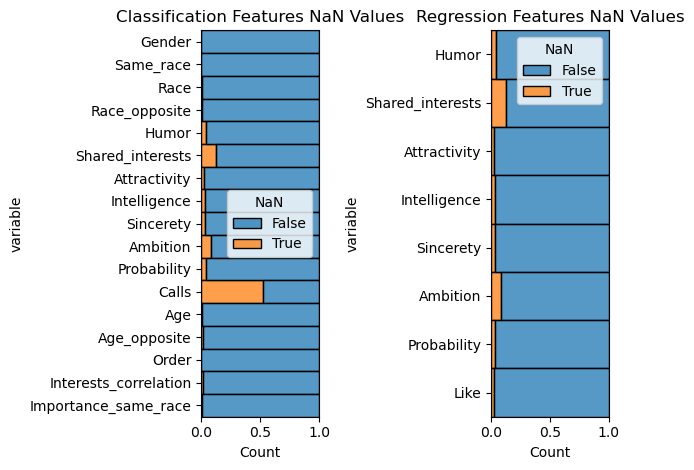

In [10]:
# For the calls variable, we assume that NaN had zero calls. This is of cause only an estimation. This value was collected after the events so not many answered this question.
# For all the other attributes we drop the NaN values because the ratio is rather small.

fig, ax2=plt.subplots(ncols=2)
g = sns.histplot(
    data=df[features_classification].isna().melt(value_name="NaN"),
    y="variable",
    hue="NaN",
    multiple="fill",ax=ax2[0]
)

g = sns.histplot(
    data=df[features_regression].isna().melt(value_name="NaN"),
    y="variable",
    hue="NaN",
    multiple="fill",ax=ax2[1]
)
ax2[0].set_title("Classification Features NaN Values")
ax2[1].set_title("Regression Features NaN Values")
fig.tight_layout()

Text(0.5, 1.08, 'Regression Features')

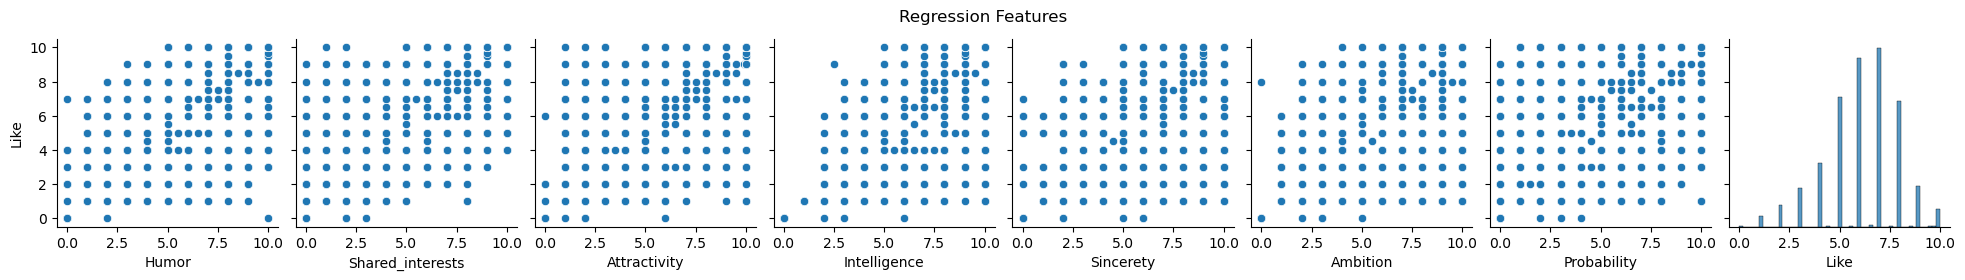

In [11]:
a=sns.pairplot(df[features_regression], y_vars='Like')
a.fig.suptitle("Regression Features",y=1.08)

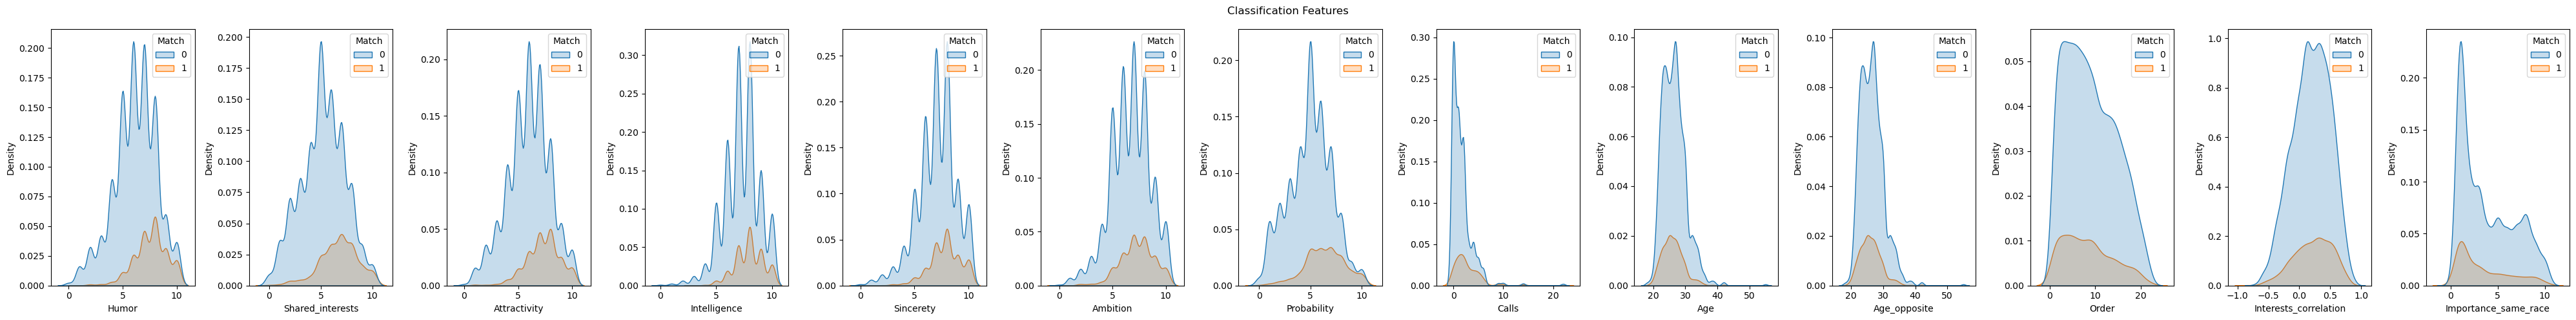

In [12]:
features=personal_features+num_features
fig, ax=plt.subplots(ncols=len(features))
for count, value in enumerate(features):
    sns.kdeplot(data=df,x=value,hue="Match",ax=ax[count],fill=True)
fig.set_size_inches(40,5)
fig.suptitle("Classification Features")
fig.tight_layout()

## Methodology

After cleaning our dataset and our initial exploratory data analysis, we can see the relationships between the respective outcome and possible predictors for each of the classification and regression.
We use the following models respectively: 
Classification:
Logistic Regression

Regression:
Linear Regression,
Multiple Regression 
Lasso
XGBOOST

Model selection process for classification:
Besides logistic regression there are other types of classification algorithms like Naïve Bayes, Stochastic Gradient Descent, K-Nearest Neighbours, Decision Tree, Random Forest and Support Vector Machine. Since we need a machine learning algorithm which is most useful for understanding the influence of several independent variables on our single outcome variable, we use the Logistic Regression, which is modelling the probabilities describing the possible outcomes of a single trial.


Platzhalter Sven

For the Logistic Regression, we use the LogisticRegressionCV model. On default, this model includes a 5 cross fold validation with Stratified K-Folds so there is no need to do further training and validation <br>
See: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegressionCV.html

The most important metrics for logicstic regression are:
- Confusion Matrix
- Precision, Recall and R1 values
- ROC value and curve

Platzhalter Alex

In [13]:
# Platzhalter Sven

              precision    recall  f1-score   support

    No match       0.85      0.98      0.91      4499
       Match       0.56      0.15      0.24       928

    accuracy                           0.83      5427
   macro avg       0.71      0.56      0.57      5427
weighted avg       0.80      0.83      0.79      5427

The ROC score is: 0.7909559060186676
              precision    recall  f1-score   support

    No match       0.76      0.73      0.75       801
       Match       0.74      0.77      0.75       799

    accuracy                           0.75      1600
   macro avg       0.75      0.75      0.75      1600
weighted avg       0.75      0.75      0.75      1600

The ROC score is: 0.8448961224030601
              precision    recall  f1-score   support

           0       0.52      0.99      0.69       199
           1       0.95      0.10      0.19       201

    accuracy                           0.55       400
   macro avg       0.74      0.55      0.44       400


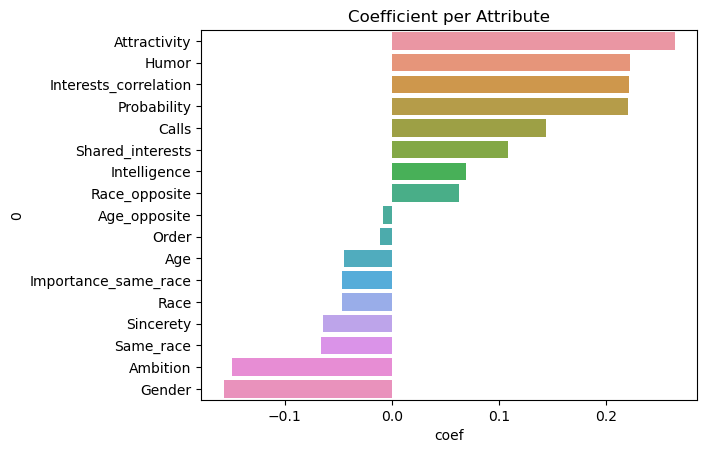

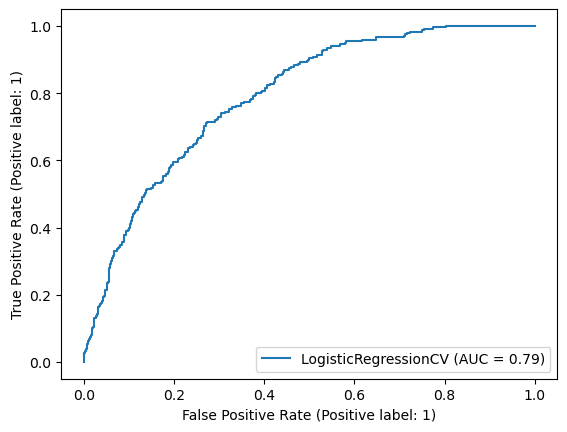

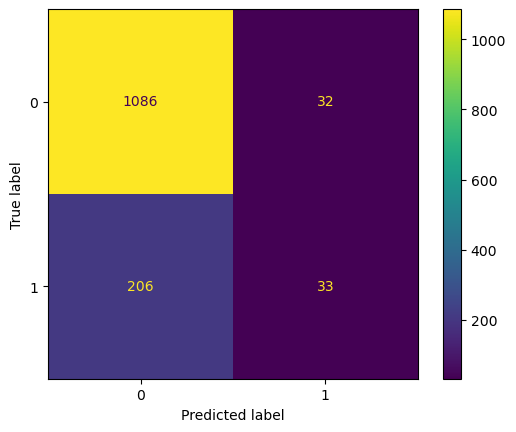

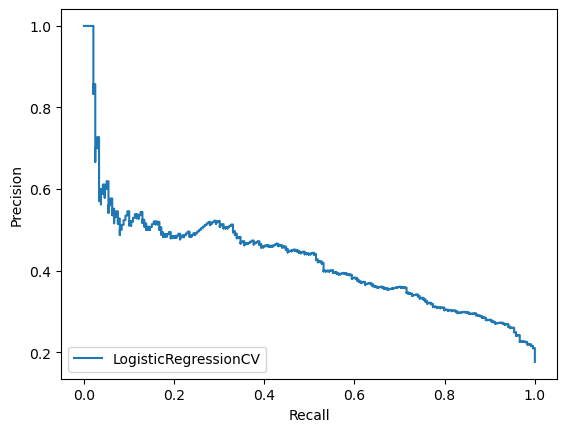

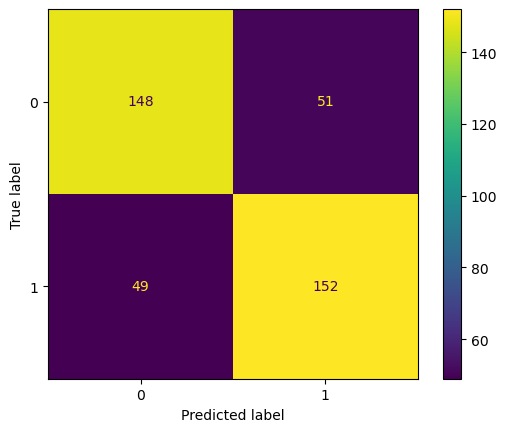

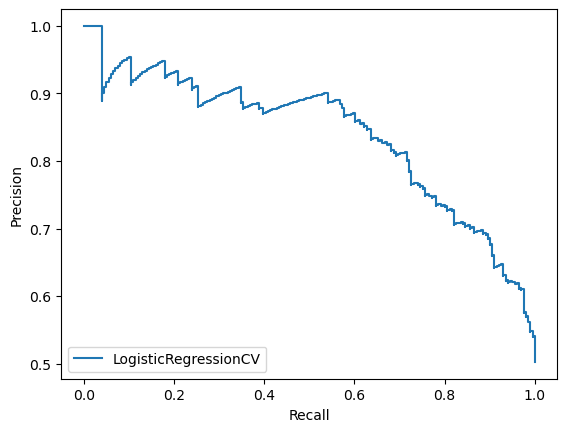

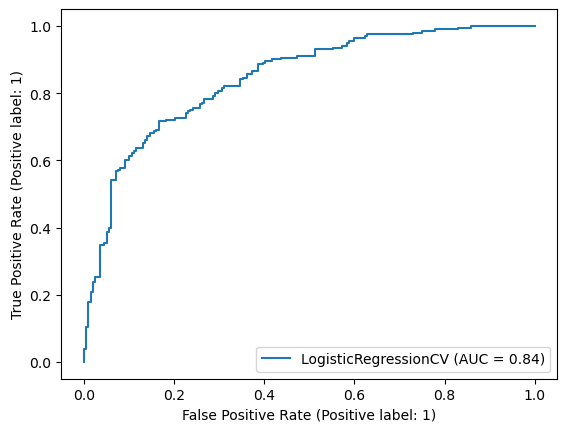

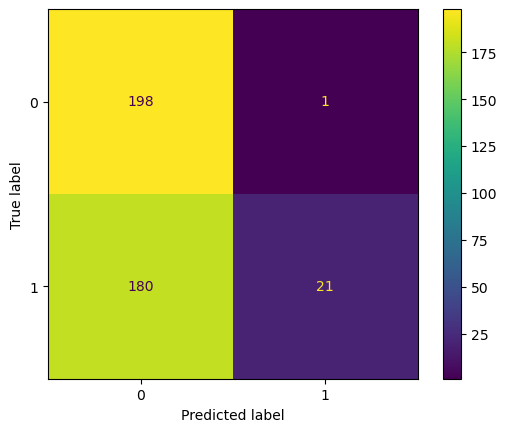

In [14]:
clf = LogisticRegressionCV(max_iter=1000)
clf.fit(X_train_c, y_train_c)
y_score_c = clf.predict_proba(X_test_c)[:, 1]

# TODO: The most important coefficients for a positive correlation for our model is attractivity, followed by humor, interests_correlation and probability. We also have strong negative correlations with Gender and Ambition. 
res = pd.DataFrame(np.row_stack(list(X_test_c.columns)))
res = res.assign(coef=clf.coef_.tolist()[0])
res.sort_values('coef',  ascending=False,inplace=True)
sns.barplot(res,y=0,x='coef').set(title="Coefficient per Attribute")

# TODO: Based on the metrics our model performs poor, predicting a lot of no matches. The R1 scor for a match is very low (0.24). There are only 33 cases where we do a correct prediction of the match outcome.
# This may be based on the origin data where we have a lot more no-match entries than matches.
# We can try to even the numbers and train the model again.
y_pred_t = clf.predict(X_train_c)
print(classification_report(y_train_c, y_pred_t, target_names=['No match', 'Match']))
y_score = clf.predict_proba(X_test_c)[:, 1]
print(f"The ROC score is: {roc_auc_score(y_test_c, y_score)}")
RocCurveDisplay.from_estimator(clf, X_test_c, y_test_c);

ConfusionMatrixDisplay.from_estimator(clf, X_test_c, y_test_c)

precision, recall, thresholds = precision_recall_curve(y_test_c, y_score_c)
disp = PrecisionRecallDisplay(precision=precision, recall=recall, estimator_name='LogisticRegressionCV')
disp.plot()

# TODO: Move to own cell
# TODO: explain to select even numbers
df_new = pd.concat([df_c[df_c[y_label_c] == 0][:1000], df_c[df_c[y_label_c] == 1][:1000]])

alt.Chart(df_new).mark_bar().encode(
    alt.X(y_label_c),
    alt.Y('count()'),
    alt.Color(y_label_c),
    tooltip = ['count()']
).properties(
    width=250,
    height=150
).interactive().properties(title="1000 match and no-match data")

# train new model
X_c = df_new[features_classification]
y_c = df_new[y_label_c]

X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X_c, y_c, 
                                                    test_size=0.2, 
                                                    shuffle=True,
                                                    random_state=42)

clf = LogisticRegressionCV(max_iter=200)
clf.fit(X_train_c, y_train_c)
y_score_c = clf.predict_proba(X_test_c)[:, 1]

# TODO: Our model looks a lot better now with a F1 score of 0.75. We do a correct estimation of match in 152 of the cases and a correct estimation of no-match in 148 so in 3/4 of all cases we are correct.
# Based on the dating behaviour it may be better to maximise the precision of match (have a lot of dates but less matches) or recall (have less dates but more matches).
# Because a match is still very personal, it is probably better to tune for precision. 

ConfusionMatrixDisplay.from_estimator(clf, X_test_c, y_test_c)

precision, recall, thresholds = precision_recall_curve(y_test_c, y_score_c)
disp = PrecisionRecallDisplay(precision=precision, recall=recall, estimator_name='LogisticRegressionCV')
disp.plot()

y_pred_t = clf.predict(X_train_c)
print(classification_report(y_train_c, y_pred_t, target_names=['No match', 'Match']))
y_score = clf.predict_proba(X_test_c)[:, 1]
print(f"The ROC score is: {roc_auc_score(y_test_c, y_score)}")
RocCurveDisplay.from_estimator(clf, X_test_c, y_test_c);

# Tuning
# The higher the thresholds, the more false negatives we have.
# If we want to tune very hard, we *could* predict 22 partners and 21 of them would be a real match (in theory).

pred_proba = clf.predict_proba(X_test_c)
df_02 = pd.DataFrame({'y_pred': pred_proba[:,1] > .9})
ConfusionMatrixDisplay.from_predictions(y_test_c, df_02['y_pred']);
print(classification_report(y_test_c, df_02['y_pred']))

In [15]:
# Platzhalter Alex

> REMOVE THE FOLLOWING TEXT

This section includes a brief description of your modeling process.

Explain the reasoning for the type of model you're fitting, predictor variables considered for the model.

Additionally, show how you arrived at the final model by describing the model selection process, variable transformations (if needed), assessment of conditions and diagnostics, and any other relevant considerations that were part of the model fitting process.

## Results

> REMOVE THE FOLLOWING TEXT

This is where you will output the final model with any relevant model fit statistics.

Describe the key results from the model.
The goal is not to interpret every single variable in the model but rather to show that you are proficient in using the model output to address the research questions, using the interpretations to support your conclusions.

Focus on the variables that help you answer the research question and that provide relevant context for the reader.


## Discussion + Conclusion


> REMOVE THE FOLLOWING TEXT

In this section you'll include a summary of what you have learned about your research question along with statistical arguments supporting your conclusions.
In addition, discuss the limitations of your analysis and provide suggestions on ways the analysis could be improved.
Any potential issues pertaining to the reliability and validity of your data and appropriateness of the statistical analysis should also be discussed here.
Lastly, this section will include ideas for future work.

## Appendix

### Tuning

              precision    recall  f1-score   support

           0       0.81      0.64      0.71       199
           1       0.70      0.85      0.77       201

    accuracy                           0.74       400
   macro avg       0.76      0.74      0.74       400
weighted avg       0.76      0.74      0.74       400



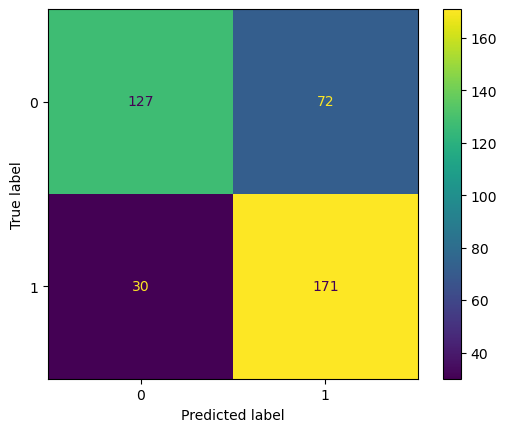

In [16]:
# The lower the thresholds, the more false positives we have. 
pred_proba = clf.predict_proba(X_test_c)
df_02 = pd.DataFrame({'y_pred': pred_proba[:,1] > .41})

ConfusionMatrixDisplay.from_predictions(y_test_c, df_02['y_pred']);

print(classification_report(y_test_c, df_02['y_pred']))


              precision    recall  f1-score   support

           0       0.52      0.99      0.69       199
           1       0.95      0.10      0.19       201

    accuracy                           0.55       400
   macro avg       0.74      0.55      0.44       400
weighted avg       0.74      0.55      0.44       400



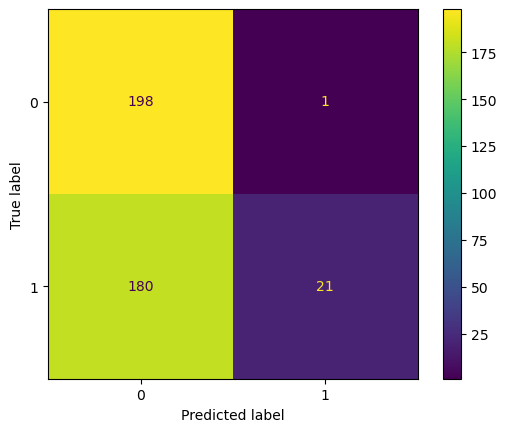

In [17]:
# The higher the thresholds, the more false negatives we have.
# If we want to tune it very hard, we can predict 22 partners and 21 of them would be a real match.

pred_proba = clf.predict_proba(X_test_c)
df_02 = pd.DataFrame({'y_pred': pred_proba[:,1] > .9})

ConfusionMatrixDisplay.from_predictions(y_test_c, df_02['y_pred']);

print(classification_report(y_test_c, df_02['y_pred']))